### Cuda Image Convolution Function Testing

In [1]:
#loading necessary libraries to run image convolution and visualize
import os
import time
import ctypes
import numpy as np
import matplotlib.pyplot as plt

#adding in our own python library after we compile
LIB_PATH = os.path.abspath("./libimageconv.so")
lib = ctypes.CDLL(LIB_PATH)

#specifying parameters and types
lib.gpu_image_conv.argtypes = [
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_int
]
lib.gpu_image_conv.restype = None


### Image Loading

In [ ]:
#normal image read and write functions in python
def load_pgm(path):
    with open(path, "rb") as f:
        assert f.readline().strip() == b"P5"
        line = f.readline()
        while line.startswith(b"#"):
            line = f.readline()
        w, h = map(int, line.split())
        f.readline()
        img = np.frombuffer(f.read(), dtype=np.uint8).reshape((h, w))
    return img.astype(np.float32)
def save_pgm(path, img):
    img = np.clip(img, 0, 255).astype(np.float32)
    h, w = img.shape
    with open(path, "wb") as f:
        f.write(b"P5\n")
        f.write(f"{w} {h}\n255\n".encode())
        f.write(img.tobytes())

input_img = load_pgm("../data/input_512.pgm")
H, W = input_img.shape


### Kernel and Filter Dim Inputs
We're using an edge tracing kernel to test

In [5]:
#testing edge tracing kernel
kernel = np.array([
    [ 0, -1,  0],
    [-1,  4, -1],
    [ 0, -1,  0]
], dtype=np.float32)

#setting filter_dim to tell cuda function later that we are working with a 3x3
#filter
filter_dim = 1
output_img = np.zeros(H * W, dtype=np.float32)



### Calling our Cuda Library

In [6]:
input_img  = input_img.reshape(-1)
kernel = kernel.reshape(-1)
output_img = output_img.reshape(-1)
start = time.time()
#calling cuda library function
lib.gpu_image_conv(
    input_img.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    kernel.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    output_img.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    ctypes.c_int(H),
    ctypes.c_int(W),
    ctypes.c_int(filter_dim)
)
end = time.time()
print(f"CUDA  runtime: {end - start:.4f} seconds")


CUDA  runtime: 0.2582 seconds


### Output Image Visualization

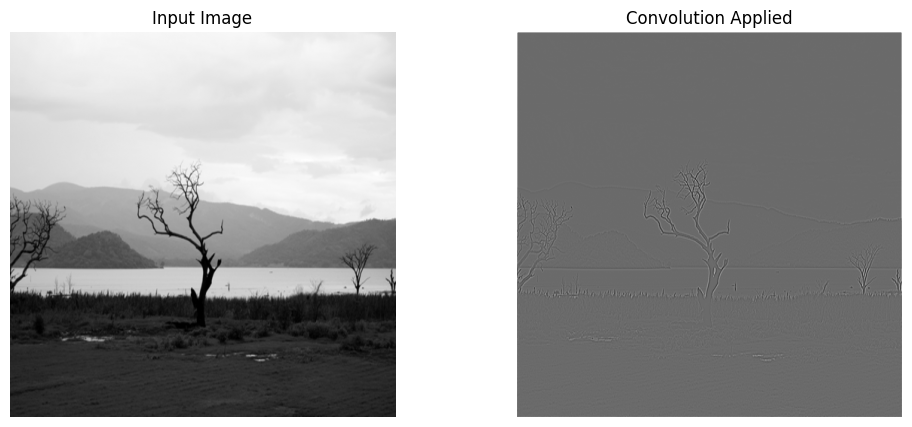

In [9]:
out = output_img.copy()
input_img=input_img.reshape(H, W)
out = out.reshape(H, W)
out -= out.min()
out /= (out.max() + 1e-8)
out = (out * 255).astype(np.uint8)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(input_img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Convolution Applied")
plt.imshow(out, cmap="gray")
plt.axis("off")

plt.show()


In [ ]:
#testing edge tracing kernel
kernel = np.array([
    [ 0, -1,  0],
    [-1,  4, -1],
    [ 0, -1,  0]
], dtype=np.float32)

#setting filter_dim to tell cuda function later that we are working with a 3x3
#filter
filter_dim = 1
trial_runs = []
for x in ["input_256.pgm","input_512.pgm","input_1024.pgm"]:
    input_img = load_pgm(f"{x}")
    H, W = input_img.shape
    output_img = np.zeros(H * W, dtype=np.float32)
    input_img  = input_img.reshape(-1)
    kernel = kernel.reshape(-1)
    output_img = output_img.reshape(-1)
    start = time.time()
    #calling cuda library function
    lib.gpu_image_conv(
        input_img.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
        kernel.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
        output_img.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
        ctypes.c_int(H),
        ctypes.c_int(W),
        ctypes.c_int(filter_dim)
    )
    end = time.time()
    trial_runs.append(end-start)

df = pd.DataFrame({"Image Size":[256,512,1024]})
df["Times"] = trial_runs
df["Times"] = df["Times"]*1000
print(df)

In [ ]:

fig, ax = plt.subplots()
ax.plot(df["Image Size"], df["Times"], marker='o')
plt.ylabel('Time (ms)')
plt.xlabel('Image Size')
plt.title('Image Size vs Runtime (ms)')
plt.show()